# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [149]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    n = mu1.shape[0]
    return 0.5*((mu2 - mu1).T @ np.linalg.inv(Sigma2) @ (mu2- mu1) + np.trace(np.linalg.inv(Sigma2) @ Sigma1) - np.log(np.linalg.det(Sigma1)/np.linalg.det(Sigma2)) - n)

In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    return np.array([-0.5*np.log(np.linalg.det(Sigma1)) + 0.5*np.linalg.det(Sigma2) -0.5*(x[i] - mu1).T @ np.linalg.inv(Sigma1) @ (x[i] - mu1) + 0.5*(x[i] - mu2).T @ np.linalg.inv(Sigma2) @ (x[i] - mu2) for i in range(x.shape[0])]) 

### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)
n = 10000
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
rho1 = 0.1
rho2 = -0.2
Sigma1 = rho1*np.ones((5,5)) + (1-rho1)*np.eye(5)
Sigma2 = rho2*np.ones((5,5)) + (1-rho2)*np.eye(5)
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)), axis=0)

In [6]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.where(y == 1)[0].shape[0]
    n2 = np.where(y == 0)[0].shape[0]
    return np.sum(t[y==1])/n1 - np.log(np.sum(np.exp(t[y == 0]))/n2)

In [150]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [8]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.3265056255255367

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [29]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)

In [31]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0524 - val_loss: -0.0622
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0649 - val_loss: -0.0724
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0719 - val_loss: -0.0797
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0863 - val_loss: -0.0852
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0860 - val_loss: -0.0896
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0900 - val_loss: -0.0933
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0929 - val_loss: -0.0967
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0909 - val_loss: -0.1000
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0982 - val_loss: -0.1032
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0980 - val_loss: -0.1064
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.1107 - val_loss: -0.1097
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

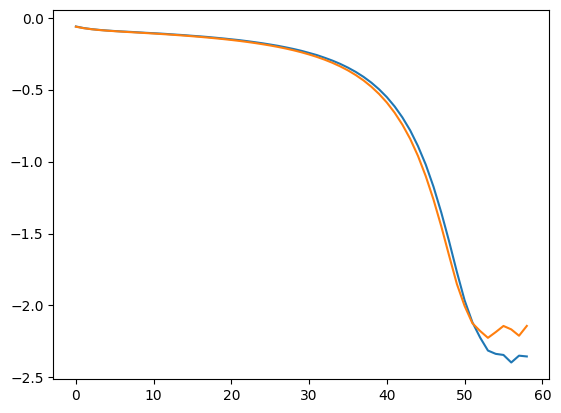

In [32]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

### e)

In [33]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step


In [34]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

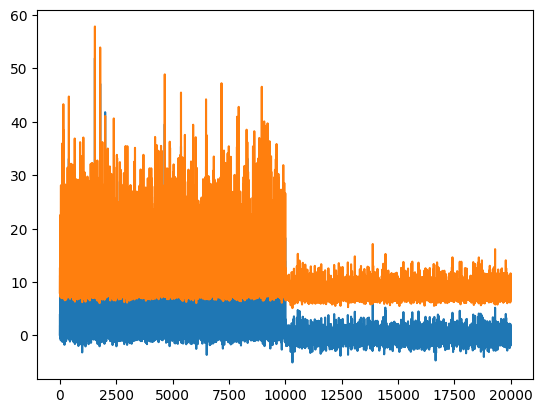

In [35]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

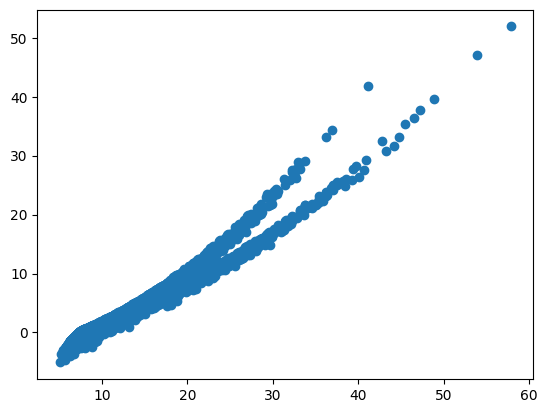

In [36]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [37]:
DV_fun(y, t_x_pred)

2.1375357806218247

In [38]:
DV_fun(y, t_x_opt)

2.3265056255255367

In [47]:
# new data
x_test1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x_test2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x_test = np.concatenate((x_test1, x_test2), axis=0)
y_test = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)), axis=0)

In [48]:
t_x_test_pred = model.predict(x_test)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


In [49]:
t_x_test_opt = T_opt(x_test, mu1, mu2, Sigma1, Sigma2)

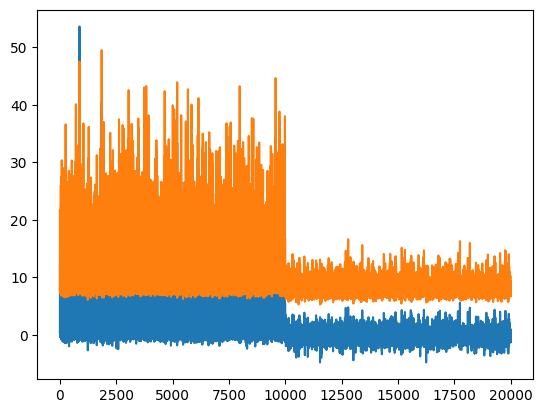

In [50]:
plt.plot(t_x_test_opt)
plt.plot(t_x_test_pred)

plt.show()

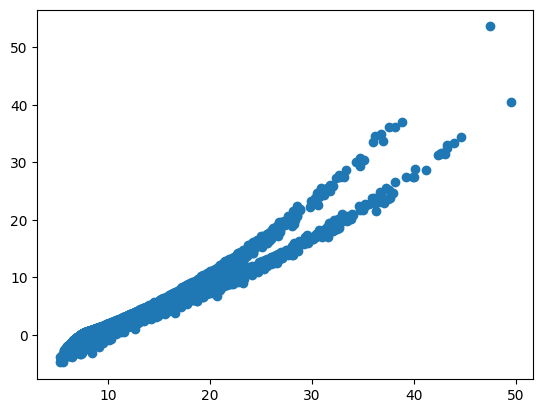

In [51]:
plt.plot(t_x_test_pred, t_x_test_opt, "o")
plt.show()

In [52]:
DV_fun(y, t_x_test_pred)

2.0425687103650514

In [45]:
DV_fun(y, t_x_test_opt)

2.2584189593942954

### f)

In [54]:
def NWJ_loss(y_true, y_pred):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(y_pred, y_true))/n1
    second_term = tf.math.reduce_sum(tf.math.multiply(tf.math.exp(y_pred - tf.convert_to_tensor(1.0)), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2
    return -(first_term - second_term) 

In [144]:
def NWJ_fun(y,t):
    n1 = np.where(y == 1)[0].shape[0]
    n2 = np.where(y == 0)[0].shape[0]
    return np.sum(t[y==1])/n1 - np.sum(np.exp(t[y == 0]-1))/n2

In [117]:
n = 10000
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
rho1 = 0.1
rho2 = -0.2
Sigma1 = rho1*np.ones((5,5)) + (1-rho1)*np.eye(5)
Sigma2 = rho2*np.ones((5,5)) + (1-rho2)*np.eye(5)
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)), axis=0)

In [118]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation='softplus')(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [119]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25)

In [120]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_val, y_val), callbacks=[es])

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0937 - val_loss: 0.0299
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: -0.0152
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -0.0231 - val_loss: -0.0421
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0464 - val_loss: -0.0588
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0596 - val_loss: -0.0690
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0736 - val_loss: -0.0760
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0793 - val_loss: -0.0810
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0880 - val_loss: -0.0846
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0861 - val_loss: -0.0882
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0951 - val_loss: -0.0913
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -0.0976 - val_loss: -0.0942
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

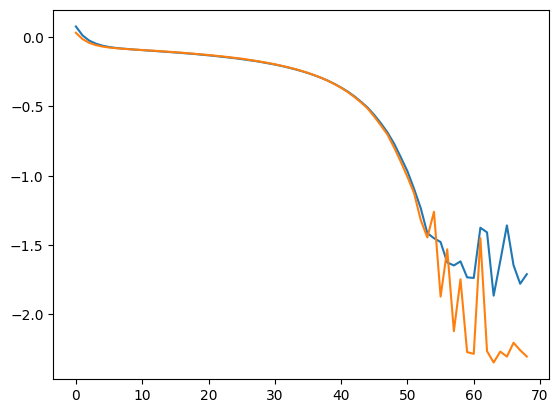

In [121]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [122]:
t_x_pred = model.predict(x)[:,0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step


In [123]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

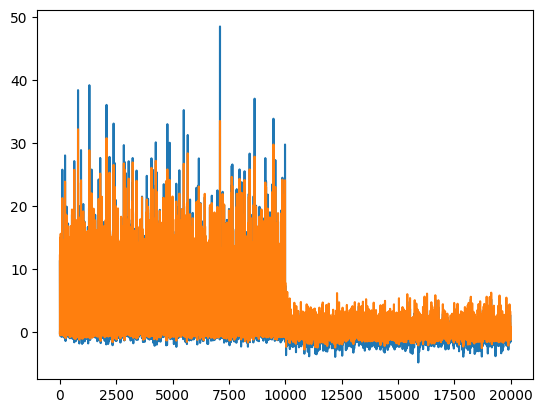

In [124]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

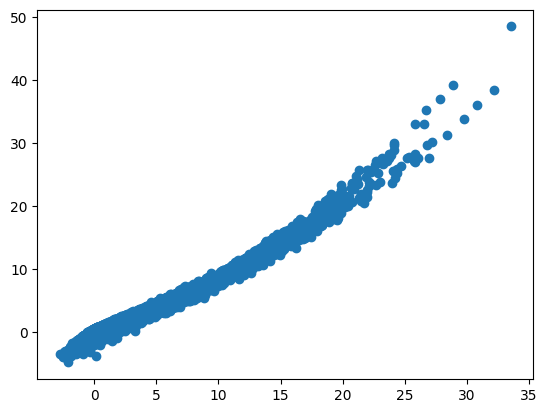

In [125]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [145]:
NWJ_fun(y, t_x_pred)

2.25196767578125

In [146]:
NWJ_fun(y, t_x_opt)

2.212481890205964

In [135]:
# new data
x_test1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x_test2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x_test = np.concatenate((x_test1, x_test2), axis=0)
y_test = np.concatenate((1.0*np.ones(n), 0.0*np.zeros(n)), axis=0)

In [136]:
t_x_test_pred = model.predict(x_test)[:,0]

  1/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


In [137]:
t_x_test_opt = T_opt(x_test, mu1, mu2, Sigma1, Sigma2)

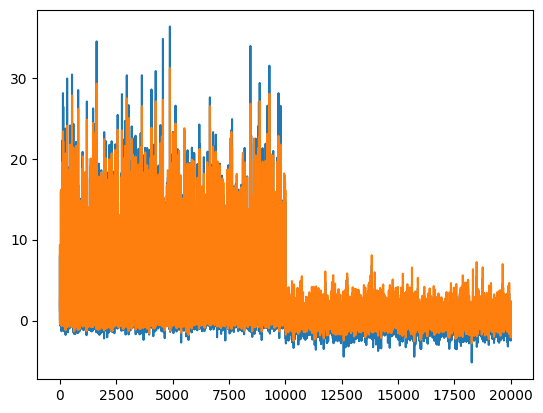

In [138]:
plt.plot(t_x_test_opt)
plt.plot(t_x_test_pred)

plt.show()

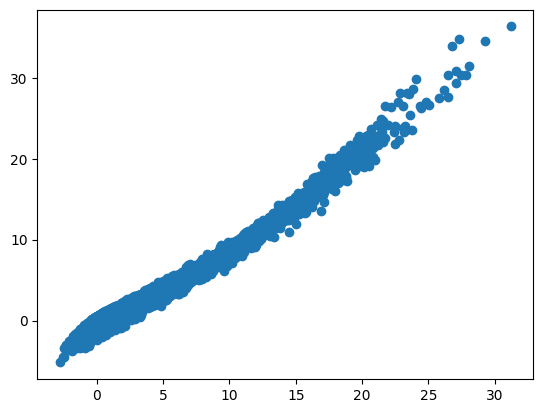

In [139]:
plt.plot(t_x_test_pred, t_x_test_opt, "o")
plt.show()

In [147]:
NWJ_fun(y, t_x_test_pred)

2.09538828125

In [148]:
NWJ_fun(y, t_x_test_opt)

2.1996277421931056